This notebook will be used for the capstone project for Coursera's IBM Data Science Professional Certificate.

In [37]:
import types
import numpy as np
import pandas as pd
from botocore.client import Config
import ibm_boto3

#data insertion block from Watson Studio
def __iter__(self): return 0



body = client_69a1a5a13fab4f0d9ffa1fbe60a2c44d.get_object(Bucket='dataanalysiscapstone-donotdelete-pr-8zrzpw4fozdt7z',Key='Data-Collisions.csv')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

df = pd.read_csv(body)
df.set_index('SEVERITYCODE')

#setting df (which will be called 'data') to include only the relevant columns: x, y, addrtype

data = pd.DataFrame()
relevant_col = ['SEVERITYCODE', 'X', 'Y', 'ADDRTYPE']

#insert relevant columns into the dataframe 'data'
for i in range (0, 4):
    data.insert(i, relevant_col[i], df[relevant_col[i]])
data.set_index('SEVERITYCODE')

data.head()


,SEVERITYCODE,X,Y,ADDRTYPE
0,2,-122.323148,47.703140,Intersection
1,1,-122.347294,47.647172,Block
2,1,-122.334540,47.607871,Block
3,1,-122.334803,47.604803,Block
4,2,-122.306426,47.545739,Intersection


In [10]:
#drop null values
data.dropna(inplace = True)

#set dummy variables for addrtype
encoded = pd.get_dummies(data['ADDRTYPE'])
data['Block'] = encoded['Block']
data['Intersection'] = encoded['Intersection']
data.drop(columns = ['ADDRTYPE'], inplace = True)
data.head()


#The data has been cleaned and prepped.  Now, it's time to bake at 400 degrees.

,SEVERITYCODE,X,Y,Block,Intersection
0,2,-122.323148,47.703140,0,1
1,1,-122.347294,47.647172,1,0
2,1,-122.334540,47.607871,1,0
3,1,-122.334803,47.604803,1,0
4,2,-122.306426,47.545739,0,1


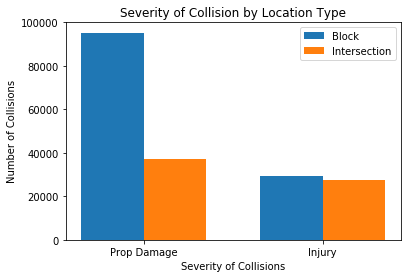

In [11]:
#PSYCH!!! Actually, we're going to do some visualization. 
#create bar graphs to show the severity codes where block = 1 and where intersection = 1

import matplotlib.pyplot as plt

block_data = data.where(data['Block'] == 1)
block_data.dropna()
int_data = data.where(data['Intersection'] == 1)
int_data.dropna()
block_data['SEVERITYCODE'].value_counts()
int_data['SEVERITYCODE'].value_counts()

#bar graph showing the severity of collisions in each type of location

block_data = block_data['SEVERITYCODE'].value_counts()
int_data = int_data['SEVERITYCODE'].value_counts()

block_data = block_data.to_frame()
block_data.reset_index(level = 0, inplace = True)
block_data = block_data.astype('int32')
int_data = int_data.to_frame()
int_data.reset_index(level = 0, inplace = True)
int_data = int_data.astype('int32')

labels = ['Prop Damage', 'Injury']
x = np.arange(len(labels))
width = 0.35

fig, ax = plt.subplots()
block_ax = ax.bar(x - width/2, block_data['SEVERITYCODE'], width, label = 'Block')
int_ax = ax.bar(x + width/2, int_data['SEVERITYCODE'], width, label = 'Intersection')

ax.set_ylabel('Number of Collisions')
ax.set_xlabel('Severity of Collisions')
ax.set_title('Severity of Collision by Location Type')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()




In [12]:
#map time!!!
'''
!conda install -c conda-forge folium=0.5.0 --yes
import folium
'''

!pip install folium
import folium

In [ ]:
#map showing all the collisions resulting in injury with their locations

seattle_injury = folium.Map(location=[47.61, -122.33], zoom_start=12)
incidents = folium.map.FeatureGroup()

for lat, long, sev in zip(data.Y, data.X, data.SEVERITYCODE):
    if (sev == 2):
        incidents.add_child(
            folium.vector_layers.CircleMarker(
                [lat, long],
                radius=0.005,
                color='black'
            )
        )
    
seattle_injury.add_child(incidents)

seattle_injury

In [ ]:
#map showing all the collisions resulting in property damage with their locations

seattle_propdamage = folium.Map(location=[47.61, -122.33], zoom_start=12)
incidents = folium.map.FeatureGroup()

for lat, long, sev in zip(data.Y, data.X, data.SEVERITYCODE):
    if (sev == 1):
        incidents.add_child(
            folium.vector_layers.CircleMarker(
                [lat, long],
                radius=0.05,
                color='black'
            )
        )
    
seattle_propdamage.add_child(incidents)

seattle_propdamage

In [33]:
#coordinates are consolidated into groups by rounding to the hundredths
#data is sorted by number of collisions to show the x,y pairs with the greatest numbers of collisions

#copy data to a new dataframe
coor = pd.DataFrame()
coor['X'] = data['X']
coor['Y'] = data['Y']

coor['X'] = coor['X'].round(2)
coor['Y'] = coor['Y'].round(2)

#group data with the same rounded coordinates together
coor = coor.groupby(['X', 'Y']).size()
coor = coor.to_frame()
coor.rename(columns = {0:'NumCollisions'}, inplace = True)
coor.reset_index(inplace = True)

#sort to show x,y pairs with the greatest numbers of collisions
coor.sort_values(by = 'NumCollisions', inplace = True, ascending = False)
coor.reset_index().drop(columns = 'index')
coor.head(10)

,X,Y,NumCollisions
133,-122.34,47.61,6198
155,-122.33,47.61,5537
154,-122.33,47.60,5199
177,-122.32,47.61,4207
156,-122.33,47.62,3942
134,-122.34,47.62,3441
112,-122.35,47.62,3147
182,-122.32,47.66,2998
178,-122.32,47.62,2979
176,-122.32,47.60,2760


In [15]:
#map showing x,y pairs with the greatest numbers of collisions

seattle_collisions = folium.Map(location=[47.61, -122.33], zoom_start=12)
incidents = folium.map.FeatureGroup()

for lat, long, num in zip(coor.Y, coor.X, coor.NumCollisions):
    rad = num / 100
    if (rad > 15): #if the number of collisions in the x,y pair is greater than 1,500
        incidents.add_child(
            folium.vector_layers.CircleMarker(
                [lat, long],
                radius = rad / 2, #radius of marker is corresponding to number of collisions
                color ='#E51CC0',
                opacity = 0.5,
                fill_color = '#E51CC0',
                fill_opacity = 0.5
            )
        )
    
seattle_collisions.add_child(incidents)

seattle_collisions